In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

np.random.seed(6)
lbl_cmap = random_label_cmap()

Using TensorFlow backend.


# Data

We assume that data has already been downloaded in via notebook [1_data.ipynb](1_data.ipynb).  
We now load images from the sub-folder `test` that have not been used during training.

In [2]:
X = sorted(glob('data/dsb2018/test/images/*.tif'))
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

In [3]:
# show all test images
if False:
    fig, ax = plt.subplots(7,8, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Load trained model

If you trained your own StarDist model (and optimized its thresholds) via notebook [2_training.ipynb](2_training.ipynb), then please set `demo_model = False` below.

In [4]:
demo_model = True

if demo_model:
    print (
        "NOTE: This is loading a previously trained demo model!\n"
        "      Please set the variable 'demo_model = False' to load your own trained model.",
        file=sys.stderr, flush=True
    )
    model = StarDist2D(None, name='2D_demo', basedir='../../models/examples')
else:
    model = StarDist2D(None, name='stardist', basedir='models')
None;

NOTE: This is loading a previously trained demo model!
      Please set the variable 'demo_model = False' to load your own trained model.


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.486166, nms_thresh=0.5.


## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [5]:
img = normalize(X[16], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

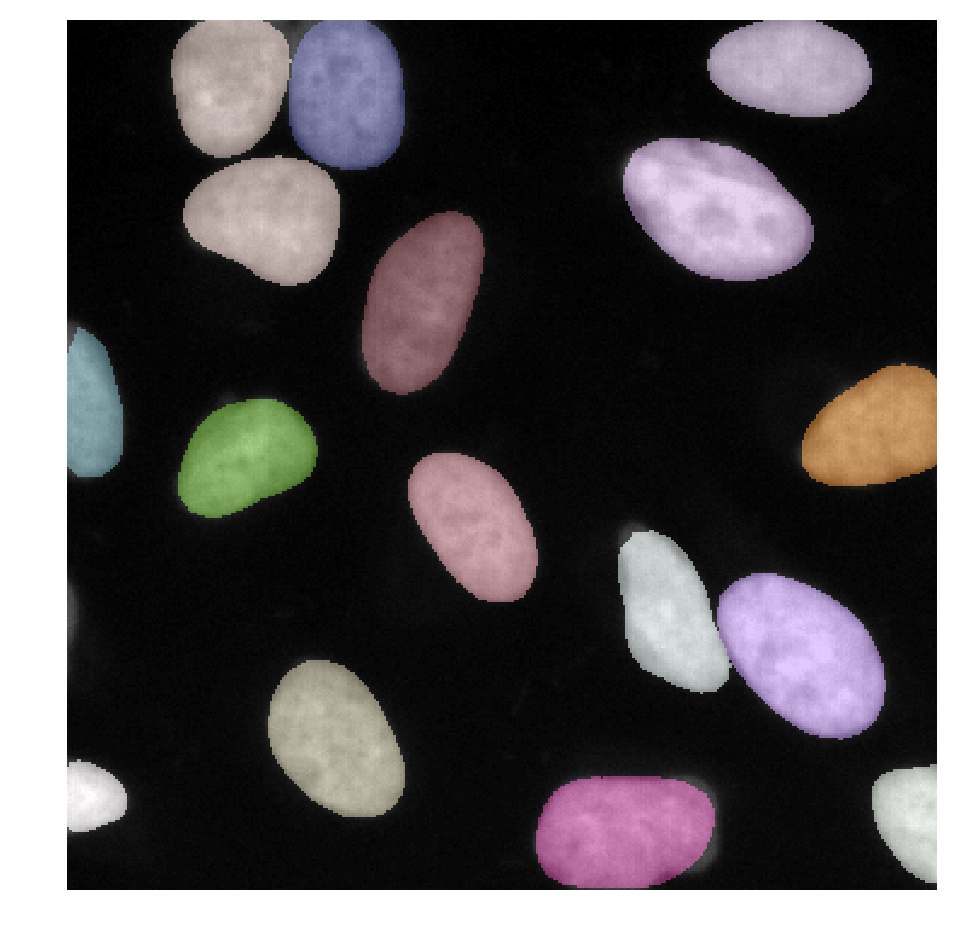

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

## Save predictions

Uncomment the lines in the following cell if you want to save the example image and the predictions to disk.  
See [this notebook](../other2D/export_imagej_rois.ipynb) for more details on how to export ImageJ ROIs.

In [7]:
# save_tiff_imagej_compatible('example_image.tif', img, axes='YX')
# save_tiff_imagej_compatible('example_labels.tif', labels, axes='YX')
# export_imagej_rois('example_rois.zip', details['coord'])

# Example results

In [8]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, grid=model.config.grid, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

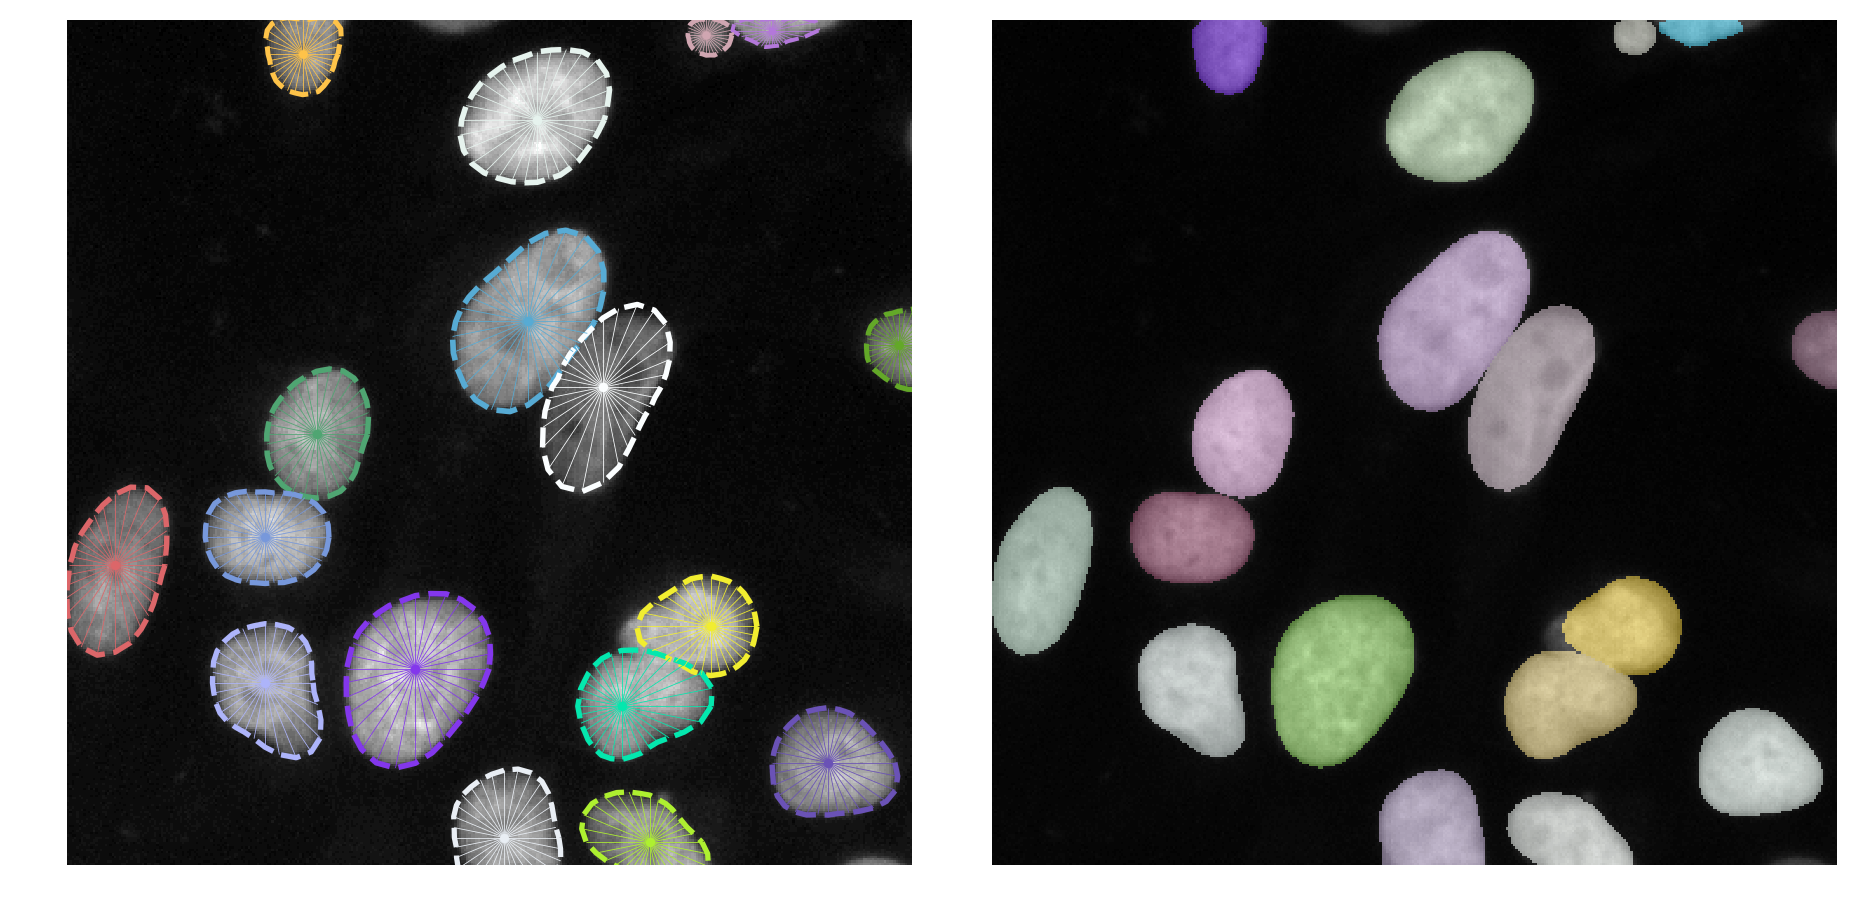

In [9]:
example(model, 42)

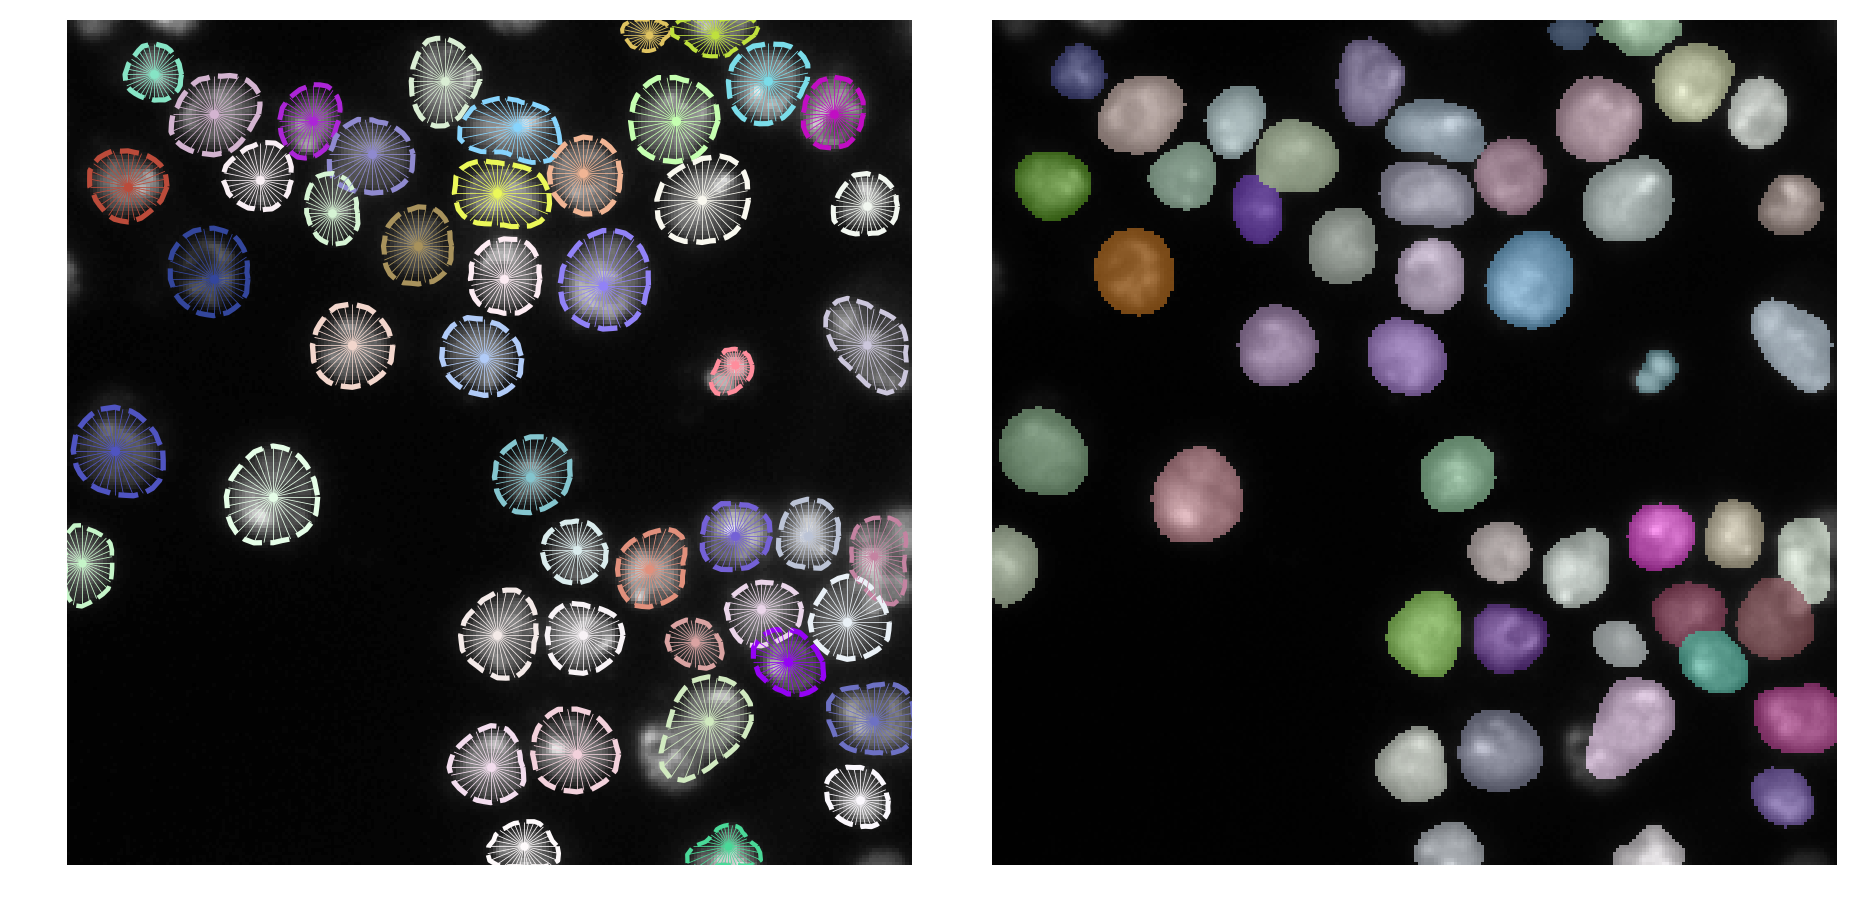

In [10]:
example(model, 1)

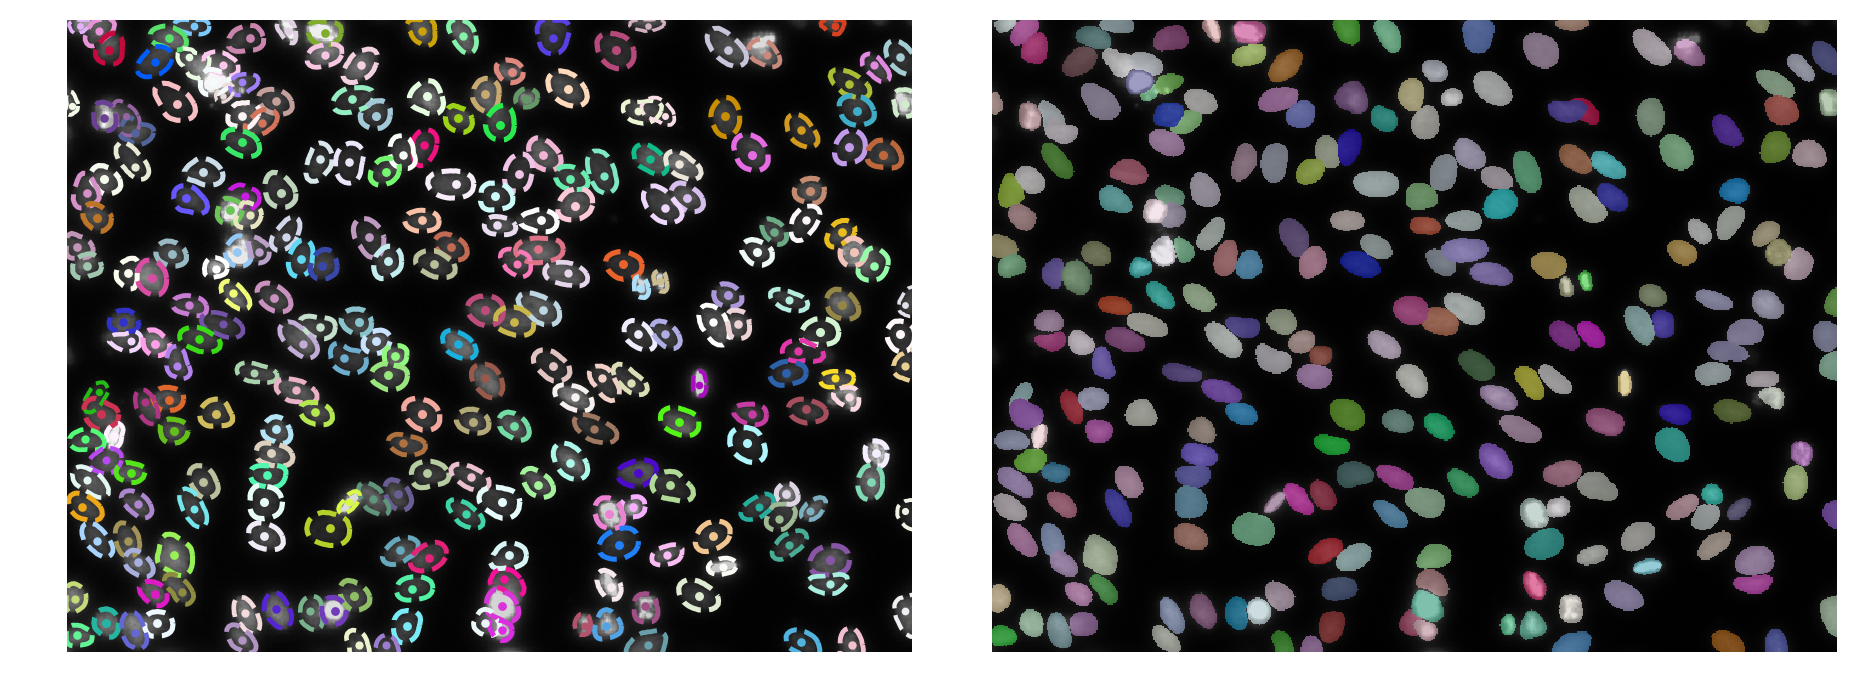

In [11]:
example(model, 15, False)

# Model from paper

In [12]:
model_paper = StarDist2D(None, name='2D_dsb2018', basedir='../../models/paper')

Loading network weights from 'weights_last.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.417819, nms_thresh=0.5.


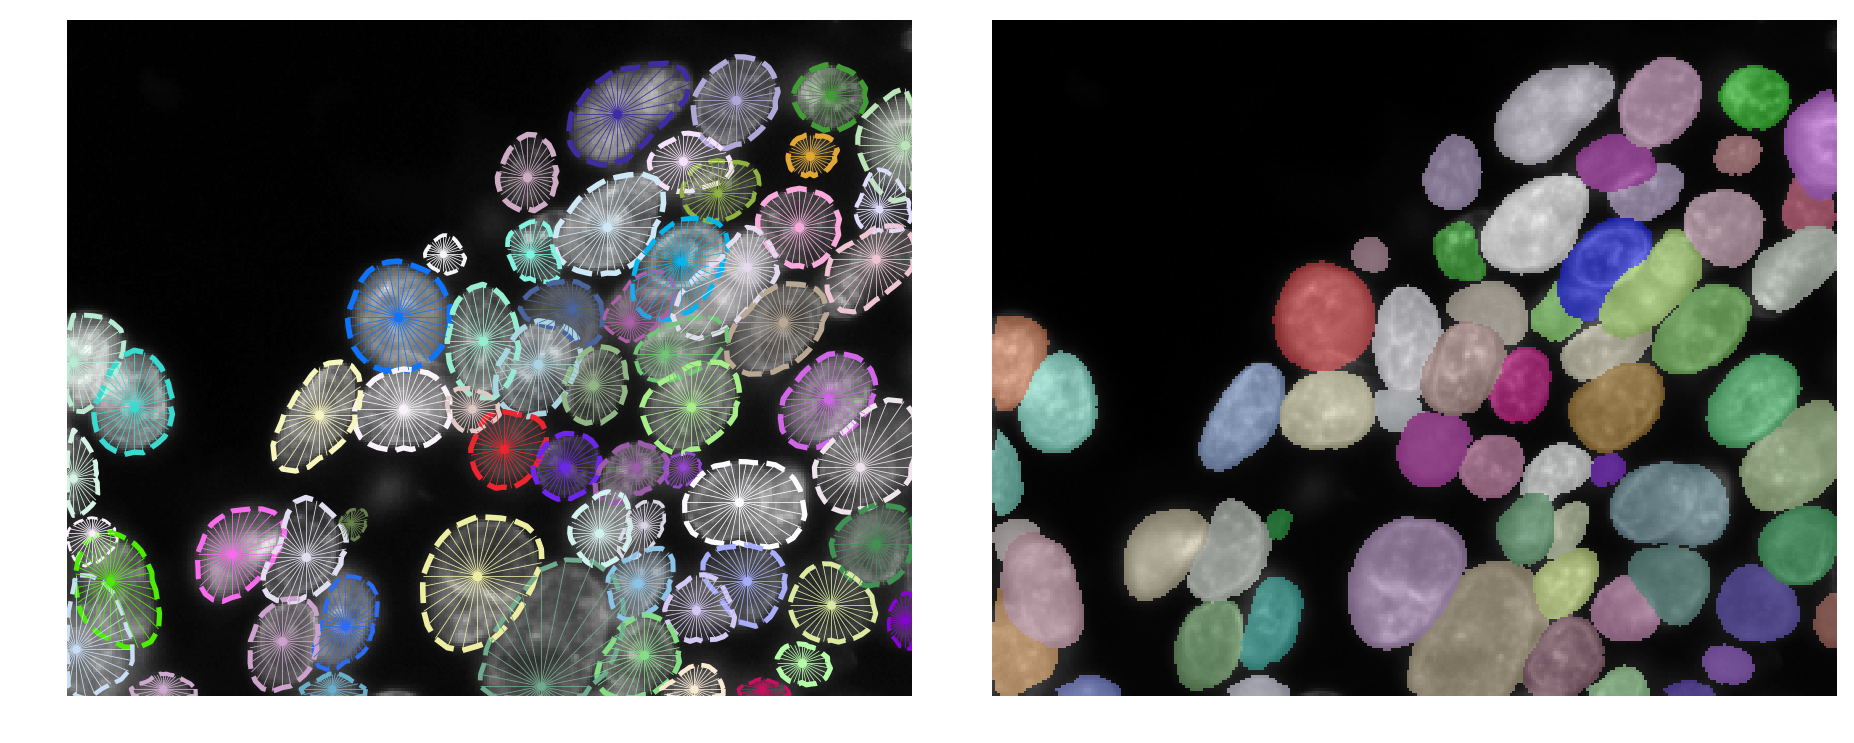

In [13]:
example(model_paper, 29)